In [8]:
import numpy as np
import pandas as pd
import shap
import optuna
from xgboost import XGBRegressor 
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [7]:
df = pd.read_csv('../data/engineered_grit_data.csv')
df.head()

,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,VCL11,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,340,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,126,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,130,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,592,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,217,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [9]:
X = df[['C8', 'C9', 'C1', 'C10', 'C5', 'C4', 'N7', 'C3', 'A10', 'C2', 'N5', 'A8', 'O2', 'E10', 'age_group_18-30']]
y = df['Grit']

X.shape

(2200, 15)

MAE_train: 0.06167246981552153
MAE_test: 0.4140040729985093
RMSE_train: 0.09356388311700392
RMSE_test: 0.5373225799826234
R2_train: 0.9821168058182422
R2_test: 0.39111650541656384
[0.14907159 0.0590253  0.08873548 0.05797023 0.0580899  0.15184915
 0.06245806 0.05190331 0.05107511 0.03733103 0.05649153 0.03984112
 0.04151087 0.03907773 0.05556965]


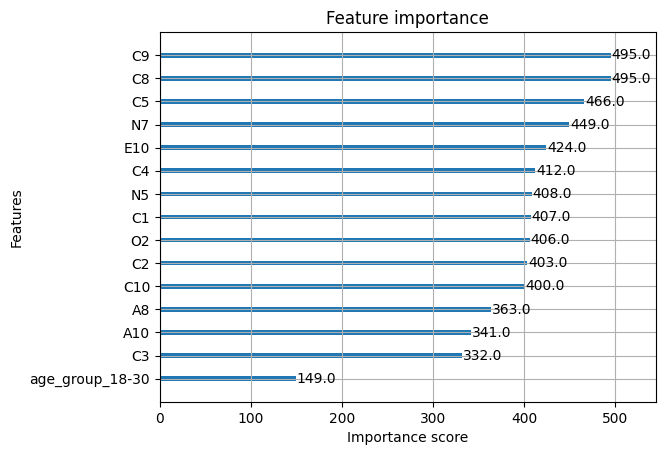

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    random_state=42
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

print(model.feature_importances_)

plot_importance(model, max_num_features=20)
plt.show()

In [11]:
param_grid = {
    'n_estimators': [200, 400, 600, 800],
    'learning_rate': [0.005, 0.01, 0.03],
    'max_depth': [3, 4, 5, 6, 8],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0, 0.01, 0.1, 1]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=100,                  
    cv=5,                      
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1               
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)

best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 0.3, 'colsample_bytree': 0.6}
Best CV score: 0.2490147516156782
MAE_train: 0.36387062908122036
MAE_test: 0.38694286003257294
RMSE_train: 0.4522478537097572
RMSE_test: 0.48647287743917655
R2_train: 0.5821872914462637
R2_test: 0.5009072255719287


In [12]:
param_grid = {
    'n_estimators': [150, 200, 600],
    'learning_rate': [0.03, 0.04, 0.05],
    'max_depth': [2, 3, 4],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4],
    'reg_alpha': [0.5, 1],
    'reg_lambda': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", -grid_search.best_score_)

best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
Best parameters: {'colsample_bytree': 0.5, 'gamma': 0.4, 'learning_rate': 0.04, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 150, 'reg_alpha': 1, 'reg_lambda': 0.001, 'subsample': 0.7}
Best CV score: 0.248766605891486
MAE_train: 0.36387062908122036
MAE_test: 0.38694286003257294
RMSE_train: 0.4522478537097572
RMSE_test: 0.48647287743917655
R2_train: 0.5821872914462637
R2_test: 0.5009072255719287


In [13]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
        "tree_method": "hist",
    }

    model = XGBRegressor(**params)

    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )

    return -cv_scores.mean()



In [14]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best Trial:")
print(study.best_trial.params)
print("Best CV score (MSE):", study.best_value)

best_params = study.best_trial.params
model = XGBRegressor(**best_params)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

print("MAE_train:", mean_absolute_error(y_train, y_pred_train))
print("MAE_test:", mean_absolute_error(y_test, y_pred_test))
print("RMSE_train:", np.sqrt(mean_squared_error(y_train, y_pred_train)))
print("RMSE_test:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R2_train:", r2_score(y_train, y_pred_train))
print("R2_test:", r2_score(y_test, y_pred_test))

[I 2025-12-14 11:30:54,022] A new study created in memory with name: no-name-851df6a3-1c92-4bce-adef-ef00af5e3e9d
Best trial: 0. Best value: 0.265552:   2%|▏         | 1/50 [00:00<00:36,  1.33it/s]

[I 2025-12-14 11:30:54,768] Trial 0 finished with value: 0.2655517116944865 and parameters: {'n_estimators': 694, 'learning_rate': 0.025964341246744144, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9815990032111814, 'colsample_bytree': 0.9736850749177013, 'gamma': 0.15112470148614832, 'reg_alpha': 3.044108094260506e-06, 'reg_lambda': 8.50748729567595}. Best is trial 0 with value: 0.2655517116944865.


Best trial: 1. Best value: 0.249889:   4%|▍         | 2/50 [00:01<00:49,  1.04s/it]

[I 2025-12-14 11:30:56,006] Trial 1 finished with value: 0.2498886045938717 and parameters: {'n_estimators': 970, 'learning_rate': 0.005280371800562267, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7141211311387372, 'colsample_bytree': 0.7512699999674366, 'gamma': 0.4347011205389195, 'reg_alpha': 1.5312269564523112e-08, 'reg_lambda': 0.9069431961936788}. Best is trial 1 with value: 0.2498886045938717.


Best trial: 1. Best value: 0.249889:   6%|▌         | 3/50 [00:02<00:41,  1.15it/s]

[I 2025-12-14 11:30:56,684] Trial 2 finished with value: 0.26127175103083883 and parameters: {'n_estimators': 255, 'learning_rate': 0.017792815169569237, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9527519897707382, 'colsample_bytree': 0.805245051295753, 'gamma': 0.3047042755104302, 'reg_alpha': 2.7353192071077306e-08, 'reg_lambda': 0.1856072505747103}. Best is trial 1 with value: 0.2498886045938717.


Best trial: 1. Best value: 0.249889:   8%|▊         | 4/50 [00:03<00:33,  1.39it/s]

[I 2025-12-14 11:30:57,170] Trial 3 finished with value: 0.261705525413567 and parameters: {'n_estimators': 234, 'learning_rate': 0.03549070139382539, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.7544256124594275, 'colsample_bytree': 0.6788805949911277, 'gamma': 0.14915407143251302, 'reg_alpha': 0.0020281891725297267, 'reg_lambda': 2.16766658357936}. Best is trial 1 with value: 0.2498886045938717.


Best trial: 4. Best value: 0.249858:  10%|█         | 5/50 [00:03<00:28,  1.58it/s]

[I 2025-12-14 11:30:57,647] Trial 4 finished with value: 0.2498580591540386 and parameters: {'n_estimators': 395, 'learning_rate': 0.014029942566348451, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.5989510870371011, 'colsample_bytree': 0.8765233681311622, 'gamma': 0.29648606078338935, 'reg_alpha': 1.0268186913319435e-06, 'reg_lambda': 0.037754494598924576}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 4. Best value: 0.249858:  12%|█▏        | 6/50 [00:04<00:30,  1.42it/s]

[I 2025-12-14 11:30:58,484] Trial 5 finished with value: 0.25109215614338876 and parameters: {'n_estimators': 876, 'learning_rate': 0.03294932028294733, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.8837586192572915, 'colsample_bytree': 0.5817616659562928, 'gamma': 0.4654721909352554, 'reg_alpha': 1.542937233113121e-07, 'reg_lambda': 4.036320435595895}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 4. Best value: 0.249858:  14%|█▍        | 7/50 [00:05<00:33,  1.27it/s]

[I 2025-12-14 11:30:59,443] Trial 6 finished with value: 0.2518092962556253 and parameters: {'n_estimators': 1008, 'learning_rate': 0.02190663618143783, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.918963280500404, 'colsample_bytree': 0.5392998955574726, 'gamma': 0.39023220104840173, 'reg_alpha': 6.708573771392731e-05, 'reg_lambda': 0.02777674348425119}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 4. Best value: 0.249858:  16%|█▌        | 8/50 [00:06<00:31,  1.35it/s]

[I 2025-12-14 11:31:00,081] Trial 7 finished with value: 0.2589948865804178 and parameters: {'n_estimators': 355, 'learning_rate': 0.005460074912735009, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.5171115418560294, 'colsample_bytree': 0.7881856782289172, 'gamma': 0.47764116680275054, 'reg_alpha': 7.031000857658983e-08, 'reg_lambda': 0.028505058571163925}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 4. Best value: 0.249858:  18%|█▊        | 9/50 [00:08<00:45,  1.12s/it]

[I 2025-12-14 11:31:02,041] Trial 8 finished with value: 0.29275229241780654 and parameters: {'n_estimators': 835, 'learning_rate': 0.026272246778715, 'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8182273004625131, 'colsample_bytree': 0.7228718710702968, 'gamma': 0.00823599318402607, 'reg_alpha': 1.0465929761514613e-06, 'reg_lambda': 9.656000463476613e-05}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 4. Best value: 0.249858:  20%|██        | 10/50 [00:09<00:44,  1.11s/it]

[I 2025-12-14 11:31:03,127] Trial 9 finished with value: 0.2644705791469003 and parameters: {'n_estimators': 865, 'learning_rate': 0.021796629068545573, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.7819237996373547, 'colsample_bytree': 0.900769692468613, 'gamma': 0.1711124601158846, 'reg_alpha': 2.4566582360788674e-07, 'reg_lambda': 0.00018437027347717168}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 4. Best value: 0.249858:  22%|██▏       | 11/50 [00:09<00:38,  1.02it/s]

[I 2025-12-14 11:31:03,807] Trial 10 finished with value: 0.2558641982366062 and parameters: {'n_estimators': 521, 'learning_rate': 0.010077917925184948, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.5988647697641011, 'colsample_bytree': 0.9091262911712803, 'gamma': 0.3026914318737841, 'reg_alpha': 7.112842210984154, 'reg_lambda': 1.524124631262693e-07}. Best is trial 4 with value: 0.2498580591540386.


Best trial: 11. Best value: 0.249141:  24%|██▍       | 12/50 [00:11<00:41,  1.09s/it]

[I 2025-12-14 11:31:05,148] Trial 11 finished with value: 0.24914082383609495 and parameters: {'n_estimators': 1198, 'learning_rate': 0.010309346196675279, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.6655444992796762, 'colsample_bytree': 0.8504922983792911, 'gamma': 0.38420032512299745, 'reg_alpha': 4.757748633564638e-05, 'reg_lambda': 0.007314100994114762}. Best is trial 11 with value: 0.24914082383609495.


Best trial: 12. Best value: 0.248533:  26%|██▌       | 13/50 [00:11<00:35,  1.05it/s]

[I 2025-12-14 11:31:05,789] Trial 12 finished with value: 0.24853273431681924 and parameters: {'n_estimators': 575, 'learning_rate': 0.010702534711208902, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.6574125318293713, 'colsample_bytree': 0.8665600979071267, 'gamma': 0.3534367873581653, 'reg_alpha': 0.0012494682616291993, 'reg_lambda': 0.0027015623477900587}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  28%|██▊       | 14/50 [00:12<00:32,  1.11it/s]

[I 2025-12-14 11:31:06,555] Trial 13 finished with value: 0.24935368330560723 and parameters: {'n_estimators': 624, 'learning_rate': 0.009299560425580056, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6654042557549456, 'colsample_bytree': 0.8452012570779885, 'gamma': 0.3769498279512594, 'reg_alpha': 0.007848711460969443, 'reg_lambda': 0.0015658979518976275}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  30%|███       | 15/50 [00:13<00:35,  1.02s/it]

[I 2025-12-14 11:31:07,847] Trial 14 finished with value: 0.2533045031443833 and parameters: {'n_estimators': 1199, 'learning_rate': 0.008649251841920797, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6433984852641766, 'colsample_bytree': 0.9896807544261784, 'gamma': 0.37176946257075927, 'reg_alpha': 0.13187978102778958, 'reg_lambda': 3.7545613306101235e-06}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  32%|███▏      | 16/50 [00:14<00:35,  1.06s/it]

[I 2025-12-14 11:31:08,995] Trial 15 finished with value: 0.2495146711823792 and parameters: {'n_estimators': 1155, 'learning_rate': 0.013219496602414827, 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.5171585343203607, 'colsample_bytree': 0.6440516862585072, 'gamma': 0.22725980066765783, 'reg_alpha': 5.7324835638444226e-05, 'reg_lambda': 0.001792546891478655}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  34%|███▍      | 17/50 [00:15<00:33,  1.00s/it]

[I 2025-12-14 11:31:09,884] Trial 16 finished with value: 0.25070087043407474 and parameters: {'n_estimators': 557, 'learning_rate': 0.007129663959996324, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.698287759341594, 'colsample_bytree': 0.9341553933604081, 'gamma': 0.23892054039944835, 'reg_alpha': 0.0658842437840077, 'reg_lambda': 7.830503150353612e-06}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  36%|███▌      | 18/50 [00:16<00:30,  1.03it/s]

[I 2025-12-14 11:31:10,762] Trial 17 finished with value: 0.2504444490782716 and parameters: {'n_estimators': 733, 'learning_rate': 0.011558242514517444, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6067690982011863, 'colsample_bytree': 0.8368062178285263, 'gamma': 0.33469681012788277, 'reg_alpha': 0.0004143825644809185, 'reg_lambda': 0.0015271418033882397}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  38%|███▊      | 19/50 [00:17<00:31,  1.01s/it]

[I 2025-12-14 11:31:11,854] Trial 18 finished with value: 0.2582555028376203 and parameters: {'n_estimators': 1066, 'learning_rate': 0.049866024285182504, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8089168615723233, 'colsample_bytree': 0.7572789715008278, 'gamma': 0.41973622022219864, 'reg_alpha': 1.5162871757931957e-05, 'reg_lambda': 1.8956655371465086e-08}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  40%|████      | 20/50 [00:18<00:27,  1.10it/s]

[I 2025-12-14 11:31:12,544] Trial 19 finished with value: 0.24888622325564555 and parameters: {'n_estimators': 448, 'learning_rate': 0.007891970720759036, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5645466767295462, 'colsample_bytree': 0.8316591827473159, 'gamma': 0.36056219541098256, 'reg_alpha': 0.0013814250511759694, 'reg_lambda': 2.548913467896686e-05}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  42%|████▏     | 21/50 [00:19<00:25,  1.15it/s]

[I 2025-12-14 11:31:13,312] Trial 20 finished with value: 0.2501176924976861 and parameters: {'n_estimators': 429, 'learning_rate': 0.007150224542443467, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.5439165009517666, 'colsample_bytree': 0.9410698906161401, 'gamma': 0.10143012240705326, 'reg_alpha': 0.027567703442985033, 'reg_lambda': 8.587254010731676e-06}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  44%|████▍     | 22/50 [00:19<00:22,  1.26it/s]

[I 2025-12-14 11:31:13,931] Trial 21 finished with value: 0.25634001465729334 and parameters: {'n_estimators': 521, 'learning_rate': 0.007595286443764165, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.5624155472919278, 'colsample_bytree': 0.8511656395845448, 'gamma': 0.3547453196277066, 'reg_alpha': 0.0005499009948912851, 'reg_lambda': 4.5817810069677006e-05}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  46%|████▌     | 23/50 [00:20<00:21,  1.26it/s]

[I 2025-12-14 11:31:14,715] Trial 22 finished with value: 0.24972422777870915 and parameters: {'n_estimators': 663, 'learning_rate': 0.011486973690597141, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6502174414866068, 'colsample_bytree': 0.8035747070275875, 'gamma': 0.43665585007169994, 'reg_alpha': 0.45659940696224055, 'reg_lambda': 0.0052831121793017535}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  48%|████▊     | 24/50 [00:21<00:21,  1.19it/s]

[I 2025-12-14 11:31:15,676] Trial 23 finished with value: 0.2599622974316479 and parameters: {'n_estimators': 778, 'learning_rate': 0.017531743552141717, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.701330357672449, 'colsample_bytree': 0.8678133178944374, 'gamma': 0.26373003047420573, 'reg_alpha': 0.004008401867862771, 'reg_lambda': 0.0005289923909028457}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  50%|█████     | 25/50 [00:22<00:20,  1.24it/s]

[I 2025-12-14 11:31:16,410] Trial 24 finished with value: 0.25119988684794897 and parameters: {'n_estimators': 471, 'learning_rate': 0.006213118415775399, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5803282289648596, 'colsample_bytree': 0.7137191384680804, 'gamma': 0.4929507917872007, 'reg_alpha': 3.952823788888651e-05, 'reg_lambda': 1.0016979416545495e-06}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  52%|█████▏    | 26/50 [00:23<00:19,  1.25it/s]

[I 2025-12-14 11:31:17,187] Trial 25 finished with value: 0.24996896586938783 and parameters: {'n_estimators': 615, 'learning_rate': 0.010591203753304315, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6355549201721402, 'colsample_bytree': 0.809512870488339, 'gamma': 0.40060734565024647, 'reg_alpha': 0.001252441001542559, 'reg_lambda': 2.9549504455311603e-05}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  54%|█████▍    | 27/50 [00:23<00:15,  1.45it/s]

[I 2025-12-14 11:31:17,616] Trial 26 finished with value: 0.2749625931318442 and parameters: {'n_estimators': 332, 'learning_rate': 0.008092684191708522, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.7301160734708105, 'colsample_bytree': 0.9017335125916394, 'gamma': 0.327920206284197, 'reg_alpha': 0.000136746566873809, 'reg_lambda': 0.00746952463790673}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  56%|█████▌    | 28/50 [00:24<00:15,  1.44it/s]

[I 2025-12-14 11:31:18,331] Trial 27 finished with value: 0.25201059756812555 and parameters: {'n_estimators': 565, 'learning_rate': 0.013278830328817002, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.676771214770963, 'colsample_bytree': 0.9500456102045178, 'gamma': 0.27039348784457307, 'reg_alpha': 1.0224835788639978e-05, 'reg_lambda': 0.00039022741505146644}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  58%|█████▊    | 29/50 [00:24<00:14,  1.47it/s]

[I 2025-12-14 11:31:18,977] Trial 28 finished with value: 0.2586671824497701 and parameters: {'n_estimators': 295, 'learning_rate': 0.006443478374730562, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.5523312491865046, 'colsample_bytree': 0.7706305937893307, 'gamma': 0.20426504811647594, 'reg_alpha': 0.00985701926054856, 'reg_lambda': 0.324962917257137}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  60%|██████    | 30/50 [00:25<00:14,  1.41it/s]

[I 2025-12-14 11:31:19,748] Trial 29 finished with value: 0.2486326591811066 and parameters: {'n_estimators': 740, 'learning_rate': 0.015767799061162577, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.6294388145460014, 'colsample_bytree': 0.8302011146688985, 'gamma': 0.34363519794105046, 'reg_alpha': 0.00027222403876793705, 'reg_lambda': 2.5552390005757533e-07}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  62%|██████▏   | 31/50 [00:26<00:14,  1.29it/s]

[I 2025-12-14 11:31:20,682] Trial 30 finished with value: 0.2521849044491457 and parameters: {'n_estimators': 702, 'learning_rate': 0.01568568897840137, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.6202599242964024, 'colsample_bytree': 0.7143931582012728, 'gamma': 0.34143788905864375, 'reg_alpha': 0.4547131051795834, 'reg_lambda': 2.6582616456715203e-07}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  64%|██████▍   | 32/50 [00:27<00:12,  1.42it/s]

[I 2025-12-14 11:31:21,223] Trial 31 finished with value: 0.2574417325399022 and parameters: {'n_estimators': 451, 'learning_rate': 0.00886923825305852, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.6832990282062477, 'colsample_bytree': 0.8251096659411679, 'gamma': 0.40208123335655677, 'reg_alpha': 0.00021423669213272605, 'reg_lambda': 1.0821645901551594e-06}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  66%|██████▌   | 33/50 [00:28<00:13,  1.25it/s]

[I 2025-12-14 11:31:22,239] Trial 32 finished with value: 0.248948330919098 and parameters: {'n_estimators': 994, 'learning_rate': 0.011755442687875203, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.7424595677097278, 'colsample_bytree': 0.8753558538917564, 'gamma': 0.4319691828794381, 'reg_alpha': 8.11242952177907e-06, 'reg_lambda': 9.528715458228154e-08}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  68%|██████▊   | 34/50 [00:29<00:13,  1.15it/s]

[I 2025-12-14 11:31:23,262] Trial 33 finished with value: 0.2513373531066954 and parameters: {'n_estimators': 962, 'learning_rate': 0.014743304142506972, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.7414509320235113, 'colsample_bytree': 0.8874490135026563, 'gamma': 0.44694998107875306, 'reg_alpha': 7.906406876133881e-06, 'reg_lambda': 3.212737031669865e-08}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  70%|███████   | 35/50 [00:30<00:13,  1.14it/s]

[I 2025-12-14 11:31:24,166] Trial 34 finished with value: 0.2577656223460515 and parameters: {'n_estimators': 805, 'learning_rate': 0.018110143288300195, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7689556614146498, 'colsample_bytree': 0.966461158083991, 'gamma': 0.3059059227483635, 'reg_alpha': 0.0009799999679944733, 'reg_lambda': 8.333029447143705e-08}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  72%|███████▏  | 36/50 [00:31<00:13,  1.03it/s]

[I 2025-12-14 11:31:25,366] Trial 35 finished with value: 0.2541725269454106 and parameters: {'n_estimators': 933, 'learning_rate': 0.012087891206309261, 'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.8369495137007017, 'colsample_bytree': 0.9117142560491817, 'gamma': 0.41855260808926165, 'reg_alpha': 2.029176438774694e-06, 'reg_lambda': 1.0221899012715888e-08}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  74%|███████▍  | 37/50 [00:32<00:13,  1.01s/it]

[I 2025-12-14 11:31:26,456] Trial 36 finished with value: 0.2532577791330002 and parameters: {'n_estimators': 1070, 'learning_rate': 0.020600407880400816, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.5002070926227856, 'colsample_bytree': 0.8635215085964856, 'gamma': 0.3608154062693164, 'reg_alpha': 0.002450861324076261, 'reg_lambda': 6.144277950543192e-07}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  76%|███████▌  | 38/50 [00:33<00:11,  1.07it/s]

[I 2025-12-14 11:31:27,226] Trial 37 finished with value: 0.25123551059901533 and parameters: {'n_estimators': 758, 'learning_rate': 0.016777617551441568, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.9917844158001816, 'colsample_bytree': 0.7796638658261018, 'gamma': 0.2861071938223477, 'reg_alpha': 0.0001679038829295976, 'reg_lambda': 4.509670354008345e-08}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  78%|███████▊  | 39/50 [00:33<00:08,  1.26it/s]

[I 2025-12-14 11:31:27,682] Trial 38 finished with value: 0.2514290221512444 and parameters: {'n_estimators': 203, 'learning_rate': 0.012445617533979648, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5780553704036931, 'colsample_bytree': 0.8223491505594088, 'gamma': 0.44528399968058324, 'reg_alpha': 0.02086978777821819, 'reg_lambda': 2.0326790217538187e-06}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  80%|████████  | 40/50 [00:34<00:07,  1.40it/s]

[I 2025-12-14 11:31:28,213] Trial 39 finished with value: 0.29295424773000633 and parameters: {'n_estimators': 378, 'learning_rate': 0.005185789205752373, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.7169319391636444, 'colsample_bytree': 0.731380990685089, 'gamma': 0.324936843922879, 'reg_alpha': 4.973122167810033e-06, 'reg_lambda': 1.612726227156277e-05}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  82%|████████▏ | 41/50 [00:35<00:07,  1.27it/s]

[I 2025-12-14 11:31:29,165] Trial 40 finished with value: 0.2541112603096905 and parameters: {'n_estimators': 915, 'learning_rate': 0.024875409556796915, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.8664114058439341, 'colsample_bytree': 0.6610454942014765, 'gamma': 0.47530949863051575, 'reg_alpha': 1.1908702051676145e-08, 'reg_lambda': 3.9826396972114704e-07}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  84%|████████▍ | 42/50 [00:36<00:06,  1.15it/s]

[I 2025-12-14 11:31:30,224] Trial 41 finished with value: 0.2488151108816658 and parameters: {'n_estimators': 1026, 'learning_rate': 0.010277035751184464, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.6269873132561403, 'colsample_bytree': 0.8766900162186683, 'gamma': 0.387862156023848, 'reg_alpha': 2.8180783672761915e-05, 'reg_lambda': 0.15800142770507794}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  86%|████████▌ | 43/50 [00:37<00:07,  1.01s/it]

[I 2025-12-14 11:31:31,574] Trial 42 finished with value: 0.25391403946059327 and parameters: {'n_estimators': 1023, 'learning_rate': 0.00974020965294894, 'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.6232264105544782, 'colsample_bytree': 0.8804366971145234, 'gamma': 0.4123346300225034, 'reg_alpha': 2.594018198994936e-05, 'reg_lambda': 0.12847940605244404}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  88%|████████▊ | 44/50 [00:38<00:06,  1.04s/it]

[I 2025-12-14 11:31:32,678] Trial 43 finished with value: 0.24938283743648243 and parameters: {'n_estimators': 1063, 'learning_rate': 0.01457657358583618, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.5776344717219286, 'colsample_bytree': 0.9219493631964502, 'gamma': 0.35301047157419907, 'reg_alpha': 6.607741093160979e-07, 'reg_lambda': 1.441222257354498}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  90%|█████████ | 45/50 [00:39<00:05,  1.11s/it]

[I 2025-12-14 11:31:33,944] Trial 44 finished with value: 0.2511682053332377 and parameters: {'n_estimators': 1137, 'learning_rate': 0.010780465561654401, 'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.5333202616555842, 'colsample_bytree': 0.7898550783768195, 'gamma': 0.4595525082865741, 'reg_alpha': 0.0004683608859798174, 'reg_lambda': 0.0789263703871068}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  92%|█████████▏| 46/50 [00:40<00:03,  1.01it/s]

[I 2025-12-14 11:31:34,659] Trial 45 finished with value: 0.2552708484136442 and parameters: {'n_estimators': 640, 'learning_rate': 0.00845070486910671, 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.9540803937838672, 'colsample_bytree': 0.885050613645882, 'gamma': 0.3823486418024473, 'reg_alpha': 0.0001098773244037268, 'reg_lambda': 7.37135908258083}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  94%|█████████▍| 47/50 [00:41<00:02,  1.03it/s]

[I 2025-12-14 11:31:35,579] Trial 46 finished with value: 0.24887554625187214 and parameters: {'n_estimators': 854, 'learning_rate': 0.006504641087632136, 'max_depth': 2, 'min_child_weight': 8, 'subsample': 0.5946296590719623, 'colsample_bytree': 0.8353565046154309, 'gamma': 0.30501913405705366, 'reg_alpha': 3.209781023750787e-06, 'reg_lambda': 0.000124566442672166}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  96%|█████████▌| 48/50 [00:42<00:02,  1.02s/it]

[I 2025-12-14 11:31:36,730] Trial 47 finished with value: 0.24987711012094654 and parameters: {'n_estimators': 867, 'learning_rate': 0.006491118411461307, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.60548717395971, 'colsample_bytree': 0.5083579867138182, 'gamma': 0.3107639132219217, 'reg_alpha': 2.339905322370035e-06, 'reg_lambda': 8.919296124712234e-05}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533:  98%|█████████▊| 49/50 [00:43<00:01,  1.00s/it]

[I 2025-12-14 11:31:37,683] Trial 48 finished with value: 0.24940048308911528 and parameters: {'n_estimators': 707, 'learning_rate': 0.00609887024440302, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6489761288781483, 'colsample_bytree': 0.8345295860010048, 'gamma': 0.2880712280360819, 'reg_alpha': 2.2044894249891672e-07, 'reg_lambda': 0.6381783639065598}. Best is trial 12 with value: 0.24853273431681924.


Best trial: 12. Best value: 0.248533: 100%|██████████| 50/50 [00:45<00:00,  1.11it/s]


[I 2025-12-14 11:31:39,194] Trial 49 finished with value: 0.25192807392943745 and parameters: {'n_estimators': 807, 'learning_rate': 0.005561141905275626, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.589322343081312, 'colsample_bytree': 0.8067379931727012, 'gamma': 0.207220244808333, 'reg_alpha': 0.005099906026772513, 'reg_lambda': 0.00013353635728885471}. Best is trial 12 with value: 0.24853273431681924.
Best Trial:
{'n_estimators': 575, 'learning_rate': 0.010702534711208902, 'max_depth': 2, 'min_child_weight': 7, 'subsample': 0.6574125318293713, 'colsample_bytree': 0.8665600979071267, 'gamma': 0.3534367873581653, 'reg_alpha': 0.0012494682616291993, 'reg_lambda': 0.0027015623477900587}
Best CV score (MSE): 0.24853273431681924
MAE_train: 0.3779387897162727
MAE_test: 0.39151910940806073
RMSE_train: 0.4708747255652518
RMSE_test: 0.48695960031339974
R2_train: 0.5470613544964973
R2_test: 0.49990802745298846


In [15]:
import pickle

with open("regression_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

#best_model.save_model("best_model.json")

In [89]:
X = df[['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2',
       'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4',
       'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8',
       'O9', 'O10', 'age_group_18-30', 'age_group_30-45',
       'age_group_45+', 'vocab_score', 'married_Currently married',
       'married_Never married', 'married_Previously married']]

MAE_train: 0.013331879314148073
MAE_test: 0.41798254079890984
RMSE_train: 0.02103482045706571
RMSE_test: 0.5319728132119403
R2_train: 0.9990961294514312
R2_test: 0.4031806508335716
[0.00436096 0.00824266 0.01015907 0.00703395 0.00910512 0.00868299
 0.0135073  0.00799392 0.00615361 0.00950371 0.00739873 0.00961325
 0.0069754  0.00794654 0.01875162 0.00988586 0.01849874 0.01323299
 0.01286502 0.01632914 0.01029553 0.0108636  0.00593393 0.01297383
 0.01283885 0.0076718  0.01533436 0.00702666 0.01059461 0.01224066
 0.06248181 0.01001864 0.02157359 0.13220388 0.03240119 0.02311956
 0.00966861 0.13107471 0.04255216 0.03653459 0.00479469 0.01552537
 0.00642576 0.00567348 0.01132899 0.00862375 0.01416071 0.00782295
 0.00826116 0.00674499 0.01986288 0.01039538 0.01579642 0.00923994
 0.00888893 0.01710905 0.01570233]


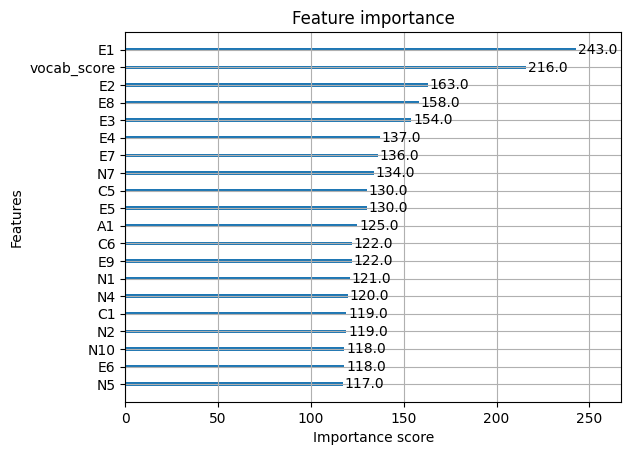

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(
    random_state=42
)

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test  = mean_absolute_error(y_test, y_pred_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
RMSE_test  = np.sqrt(mean_squared_error(y_test, y_pred_test))

R2_train = r2_score(y_train, y_pred_train)
R2_test  = r2_score(y_test, y_pred_test)

print("MAE_train:", MAE_train)
print("MAE_test:", MAE_test)

print("RMSE_train:", RMSE_train)
print("RMSE_test:", RMSE_test)

print("R2_train:", R2_train)
print("R2_test:", R2_test)

print(model.feature_importances_)

plot_importance(model, max_num_features=20)
plt.show()

In [91]:
params = model.get_params()
print(params)

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
